<a href="https://colab.research.google.com/github/FSNLSTR/PythonProjects/blob/main/MLSP_Project02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import numpy as np
import pandas as pd
import librosa as lb
import matplotlib.pyplot as plt
from scipy import io
import seaborn as sns
from IPython.display import Audio

**Problem 1**

In [ ]:
x, sr = lb.load('x.wav', sr = None)
print('Original data shape is: ' + str(x.reshape(-1,1).shape))

Original data shape is: (96245, 1)


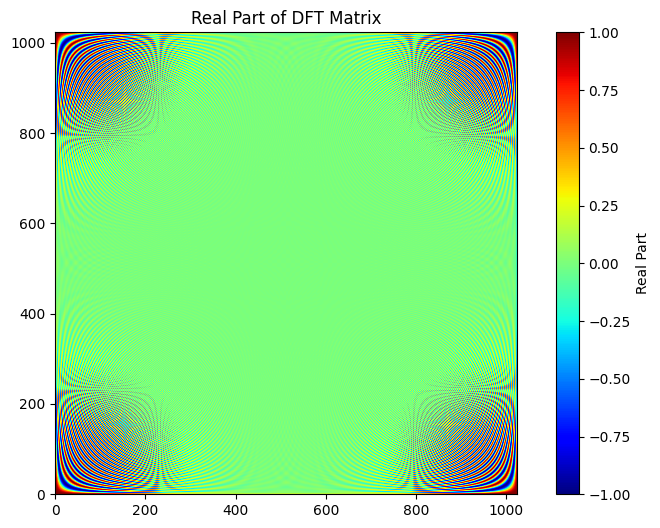

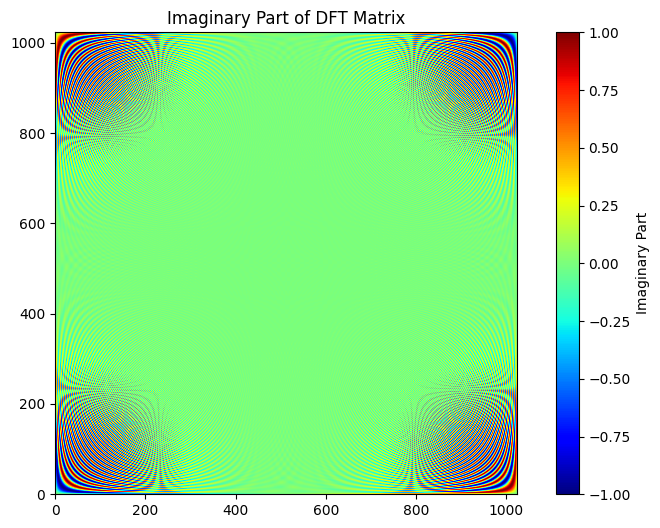

In [ ]:
def dft_matrix(m_size):
    dft_matrix = np.array([[np.exp(-1j * (2 * np.pi * f * n / m_size)) for f in range(0, m_size)] for n in range(0, m_size)])
    return dft_matrix

N = 1024
dft = dft_matrix(N)
dft.shape
# Plot real part of DFT matrix
plt.figure(figsize=(10, 6))
plt.imshow(np.real(dft),cmap='jet', origin='lower')
plt.colorbar(label='Real Part')
plt.title('Real Part of DFT Matrix')
plt.show()

# Plot imaginary part of DFT matrix
plt.figure(figsize=(10, 6))
plt.imshow(np.imag(dft), cmap='jet', origin='lower')
plt.colorbar(label='Imaginary Part')
plt.title('Imaginary Part of DFT Matrix')
plt.show()

In [ ]:
def h_window(data, size):
  hann = np.hanning(size)
  new_data = []
  counter = 0

  while (counter + size) <= data.shape[0]:
    window = np.multiply(data[counter:counter+size], hann)
    new_data.append(window)

    counter += int(size/2)

  new_matrix = np.array(new_data).T

  return new_matrix

X_updated = h_window(x, N)
X_updated.shape

(1024, 186)

(1024, 186)


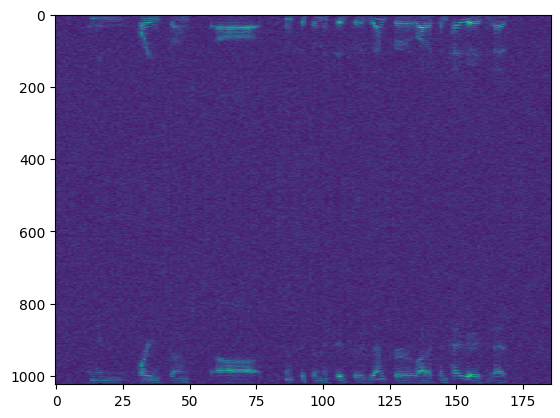

In [ ]:
y = dft @ X_updated
spectrogram = np.abs(y)**.5
print(spectrogram.shape)

plt.imshow(spectrogram, aspect='auto')
plt.show()

In [ ]:
# Select frames from the last portion of the spectrogram
num_frames = spectrogram.shape[1]
#noise_frames_indices = range(num_frames - num_frames // 10, num_frames)  # Select last tenth of frames
noise_frames_indices = range(175, num_frames)  # Select last tenth of frames

# Compute sample mean of magnitudes for chosen noise frames
M = np.mean(spectrogram[:, noise_frames_indices], axis=1)
print(M)

[0.91669106 1.05496284 1.05704699 ... 0.883064   1.05704699 1.05496284]


In [ ]:
# Subtract noise model from magnitude spectra
cleaned_Y_magnitude = spectrogram - M[:, np.newaxis]

# Ensure no negative values
cleaned_Y_magnitude[cleaned_Y_magnitude < 0] = 0

# Get original phase from input spectrogram
phase = y / spectrogram

# Reconstruct complex-valued spectra of estimated clean speech
cleaned_Y = cleaned_Y_magnitude * phase
print(cleaned_Y.shape)

(1024, 186)


In [ ]:
def idft_matrix(m_size):
    dft_matrix = np.array([[np.exp(1j * (2 * np.pi * f * n /m_size)) for f in range(0,m_size)] for n in range(0,m_size)])
    idft_matrix = dft_matrix/m_size
    return idft_matrix

inverse_dft = idft_matrix(N)
inverse_dft.shape

(1024, 1024)

In [ ]:
f_star_f = inverse_dft @ dft
print(str(np.abs(np.round(f_star_f.real))))

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


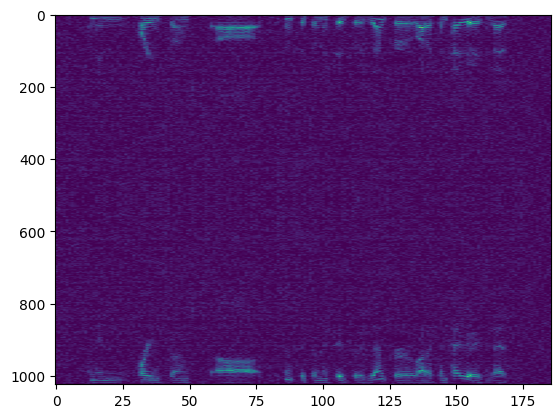

In [ ]:
plt.imshow(np.abs(cleaned_Y)**0.5, aspect='auto')
plt.show()

In [ ]:
denoised = np.real(inverse_dft @ cleaned_Y).T

overlap = N//2
# Overlap-and-add to reconstruct the time-domain signal
recovered_signal = np.zeros(len(x))
for i in range(denoised.shape[0]):
    start_idx = i * overlap
    end_idx = start_idx + N
    recovered_signal[start_idx:end_idx] += denoised[i]

In [ ]:
print('Original audio file ')
Audio(x, rate = 16000)

Original audio file 


In [ ]:
print('Cleaned audio file ')
Audio(recovered_signal, rate = 16000)

Cleaned audio file 


**Problem 2**

In [ ]:
s, sr = lb.load('s.wav', sr = None)
print('Original data shape is: ' + str(x.reshape(-1,1).shape))

Original data shape is: (96245, 1)


In [ ]:
num_samples = 8

def pca(num_repetitions):
  # Initialize the data matrix X
  X = np.zeros((num_samples, num_repetitions))

  # Randomly select consecutive samples and fill X
  for i in range(num_repetitions):
    start_index = np.random.randint(0, len(s) - num_samples)
    end_index = start_index + num_samples
    X[:, i] = s[start_index:end_index]
  print(X.shape)
  cov_matrix = np.cov(X)
  eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

  return eigenvalues, eigenvectors

In [ ]:
eigenvalues, eigenvectors = pca(10)
w = eigenvectors
w.shape

(8, 10)


(8, 8)

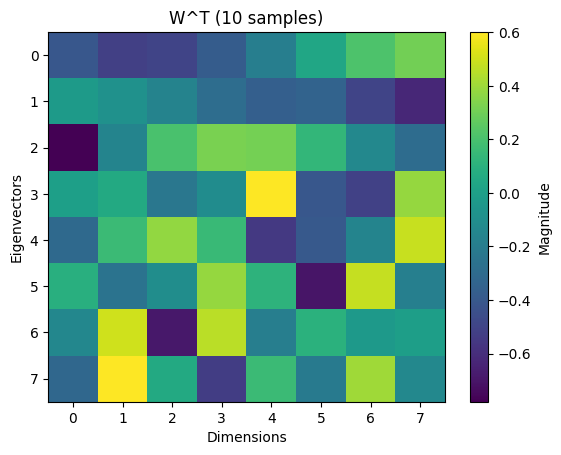

In [ ]:
# Plot W^T matrix
plt.imshow(w.T, aspect='auto')
plt.title("W^T (10 samples)")
plt.xlabel("Dimensions")
plt.ylabel("Eigenvectors")
plt.colorbar(label="Magnitude")
plt.show()

(8, 100)
(8, 1000)


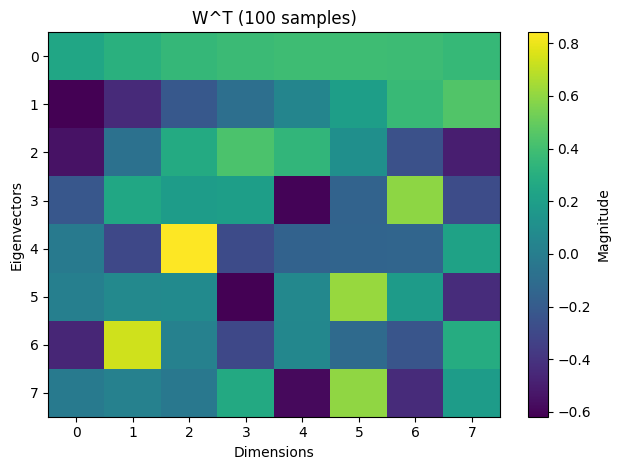

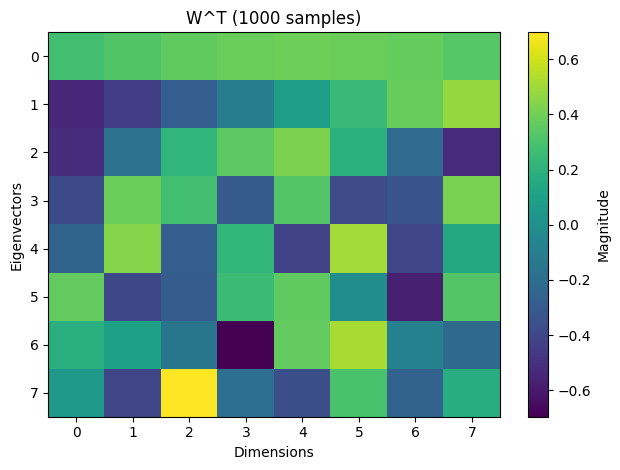

In [ ]:
# Perform PCA on each set of samples
eigenvalues_100, eigenvectors_100 = pca(100)
eigenvalues_1000, eigenvectors_1000 = pca(1000)

# Plot eigenvectors
plt.imshow(eigenvectors_100.T, aspect='auto')
plt.title('W^T (100 samples)')
plt.xlabel('Dimensions')
plt.ylabel('Eigenvectors')

plt.colorbar(label="Magnitude")

plt.tight_layout()
plt.show()

plt.imshow(eigenvectors_1000.T, aspect='auto')
plt.title('W^T (1000 samples)')
plt.xlabel('Dimensions')
plt.ylabel('Eigenvectors')

plt.colorbar(label="Magnitude")

plt.tight_layout()
plt.show()

PCA certainly offers a valuable means of dimensionality reduction by identifying principal components that capture maximal variance in the data. It facilitates more efficient storage and computation, while the orthogonal nature of the principal components aids in decorrelating the data. However, PCA's assumption about the linearity that it expects to see and its focus on capturing global variance can limit its effectiveness in nonlinear datasets. On the other hand, DCT is more adept at concentrating the signal focus in a small number of coefficients, making it significantly more suited for compression and denoising tasks. Its orthogonality and attention given to perturbations offer benefits in signal processing. Many DCT-based algorithms operate on fixed-size blocks of data, which can introduce blocking artifacts. This limitation may affect the perceived quality of compressed images or audio. Additionally, DCT is primarily used for transform-based coding, meaning that it requires a transformation step followed by quantization and entropy coding. While that's probably ok for an assignment like this, it may not be suitable for real-time applications or systems with limited computational resources.

Problem 3

In [ ]:
june = io.loadmat('june.mat')['june']
december = io.loadmat('december.mat')['december']

print(june.shape)
print(december.shape)

(2700, 2)
(2700, 2)


In [ ]:
disp_matrix = (december[:,0] - june[:,0]).reshape(-1,1)
disp_matrix.shape

(2700, 1)

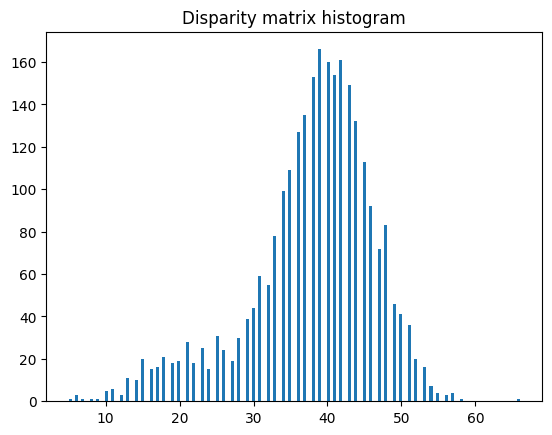

In [ ]:
plt.title('Disparity matrix histogram')
plt.hist(disp_matrix, bins = 150)
plt.show()

The cluster means found using KM are 24.358736059479554 and 41.22664199814986


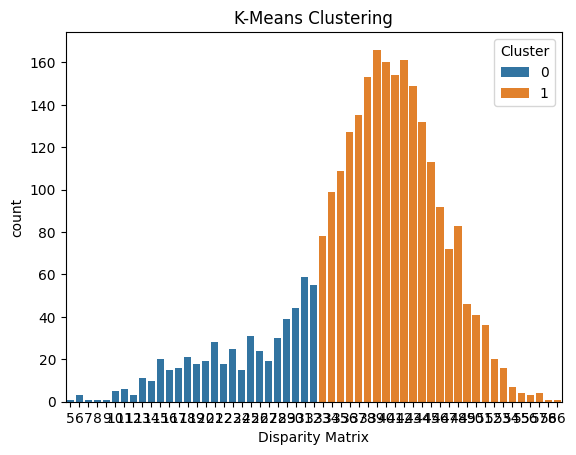

In [ ]:
def k_Means_Clustering(matrix, cluster_count, max_iter, tolerance):
  element_count = len(matrix)
  l = min(matrix)[0]
  h = max(matrix)[0]

  clusters = np.random.uniform(low = l, high = h, size = cluster_count).reshape(-1,1)
  c_matrix = np.array([[0.0] * cluster_count] * element_count)

  iteration = 0
  while iteration <= max_iter:
    for i in range(0, element_count):
      if (np.abs(matrix[i] - clusters[1])) > (np.abs(matrix[i] - clusters[0])):
        c_matrix[i][0] = 1
        c_matrix[i][1] = 0
      else:
        c_matrix[i][1] = 1
        c_matrix[i][0] = 0

    iteration += 1
    previous_cluster = clusters
    clusters = (np.dot(matrix.T, c_matrix) / np.sum(c_matrix, axis = 0)).reshape(-1)

    if np.abs(clusters[0] - previous_cluster[0]) < tolerance and np.abs(clusters[1] - previous_cluster[1]) < tolerance:
      break

  print('The cluster means found using KM are ' + str(clusters[0]) + ' and ' + str(clusters[1]))

  df = pd.DataFrame(matrix)
  df.columns = ['Disparity Matrix']
  df['Cluster'] = np.argmax(c_matrix, axis = 1)

  return df

df = k_Means_Clustering(disp_matrix, cluster_count = 2, max_iter = 1000, tolerance = 0.0001)
sns.countplot(x='Disparity Matrix', hue='Cluster', data=df)
plt.title("K-Means Clustering")
plt.show()

From the two histograms above, we can see there are two clusters with different means as represented by overlapping gaussian distributions. Since we can expect the stars that are visible in our own galaxy to be more positionally variable as opposed to those in the in the neighboring galaxy, I'd expect 41.22 to represent our galaxy, and 24.35 to correspond to the neighboring galaxy.

Problem 4

The cluster means found using EM are: 25.872808252235394 and 40.76561464493902


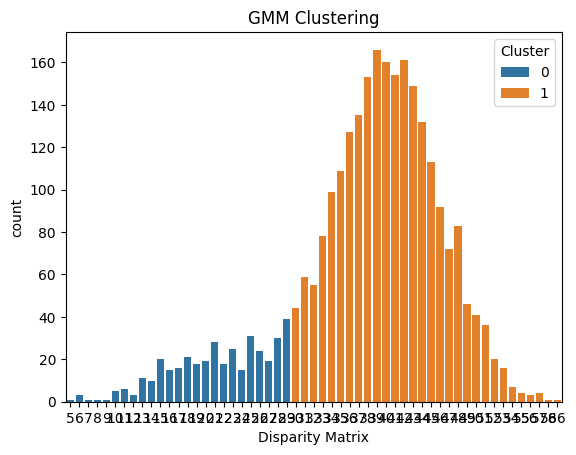

In [ ]:
def pdf_dist_normal(mu, sd, x):
  pdf = (1/np.sqrt((2*np.pi*(sd**2)))) * (np.exp(-(((x-mu)**2)/(2*(sd**2)))))
  return pdf

def EM(matrix, cluster_count, max_iter, tolerance):
  flattened_matrix = matrix.flatten()

  mu_A, mu_B = np.random.choice(flattened_matrix, size=cluster_count, replace=False)
  sd_A, sd_B = np.random.uniform(0, 10, size=cluster_count)
  p_A, p_B = 0.2, 0.8

  iteration = 0

  while iteration <= max_iter:
    pX_given_A = pdf_dist_normal(mu_A, sd_A, matrix)
    pX_given_B = pdf_dist_normal(mu_B, sd_B, matrix)

    pX_given_A[pX_given_A == 0] = 0.05
    pX_given_B[pX_given_B == 0] = 0.05

    # E Step
    s = ((p_A * pX_given_A) + (p_B * pX_given_B))

    likelihood_A = (p_A * pX_given_A)/s
    likelihood_B = (p_B * pX_given_B)/s

    old_mu_A = mu_A
    old_mu_B = mu_B

    # M Step
    mu_A = np.sum(likelihood_A * matrix)/np.sum(likelihood_A)
    mu_B = np.sum(likelihood_B * matrix)/np.sum(likelihood_B)

    sd_A = np.sqrt(np.sum(likelihood_A * (matrix - mu_A) * (matrix - mu_A))/np.sum(likelihood_A))
    sd_B = np.sqrt(np.sum(likelihood_B * (matrix - mu_B) * (matrix - mu_B))/np.sum(likelihood_B))

    iteration += 1

    if np.abs(mu_A - old_mu_A) < tolerance and np.abs(mu_B - old_mu_B) < tolerance:
      break

  print('The cluster means found using EM are: ' + str(mu_A)+ ' and ' + str(mu_B))

  c_matrix = np.argmax(np.concatenate((likelihood_A, likelihood_B), axis = 1), axis = 1)
  EM_df = pd.DataFrame(matrix)
  EM_df.columns = ['Disparity Matrix']
  EM_df['Cluster'] = c_matrix

  return EM_df

EM_df = EM(disp_matrix, 2, 1000, 0.0001)

sns.countplot(x='Disparity Matrix', hue='Cluster', data=EM_df)
plt.title("GMM Clustering")
plt.show()

From the plot above, what we can see is that GMM has overall done a better job than k-means in clustering the neighbouring galaxy stars from our galaxy stars. Traditionally, KM tends to form spherical clusters around their centroids due to its reliance on distance-based clustering. This spherical shape can limit its ability to capture more complex or elongated cluster shapes. In contrast, GMM uses a more eliplical shape to more flexibly outline the mean which may better represent the underlying distribution of data points, particularly in scenarios where clusters have different variances or orientations. Additionally, KM uses a more hard metric in distance being used as a decision boundry while GMM uses probability of a data point belonging to a specific cluster, so it's decision boundary is a lot softer. This allows for a more nuanced cluster assignments and better accommodation of data points near cluster boundaries.

In [ ]:
%%shell
jupyter nbconvert --to html //MLSP_Project02-3.ipynb

[NbConvertApp] WARNING | pattern '//MLSP_Project02-3.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--exec

CalledProcessError: Command 'jupyter nbconvert --to html //MLSP_Project02-3.ipynb
' returned non-zero exit status 255.